# Normalization and batch correction

## Settings

#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

In [20]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'Esophagus'

In [21]:
# choose normalization method. If None, two normalization methods will be 
# performed and visualized with pca plot
norm_method=None  # can be 'tfidf' or 'total'
log_normalize=True

# Options for highly variable genes
min_limit = 1000
max_limit = 5000

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_correction=False

# save figures
save_figs = False

## Loading packages and setup

In [22]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [23]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [24]:
# probably updated in future
qc_output = tree.qc_anndata  # path to qc_adata should be here
adata = epi.read_h5ad(qc_output)
adata

AnnData object with n_obs × n_vars = 37068 × 148047
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'hvg', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

## Normalization

In [25]:
# Consider using parts of sctoolbox.analyser

In [26]:
if norm_method == 'tfidf':
    epi.pp.tfidf(adata, norm='l1', layer_tfidf_key='tf-idf')
if norm_method == 'total':
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
#if not norm_method:
#    atac_norm(adata)  #a function that performs both norm methods and pca for each method, then plots so the user can choose

In [27]:
if log_normalize:
    epi.pp.log1p(adata)

## Find highly variable genes

In [28]:
an.annot_HVG(adata, hvg_range=(min_limit, max_limit))

NameError: name 'figure_path' is not defined

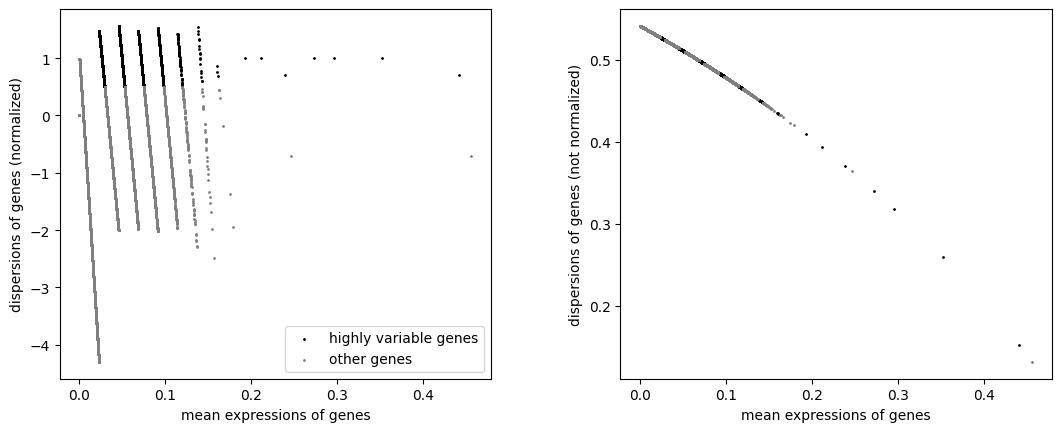

In [29]:
# FIXME add Paths to save
sc.pl.highly_variable_genes(adata, show=False)
utils.save_figure(figure_path + "highly_variable.pdf")

In [ ]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

## PCA

In [30]:
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

## Calc Neighbours

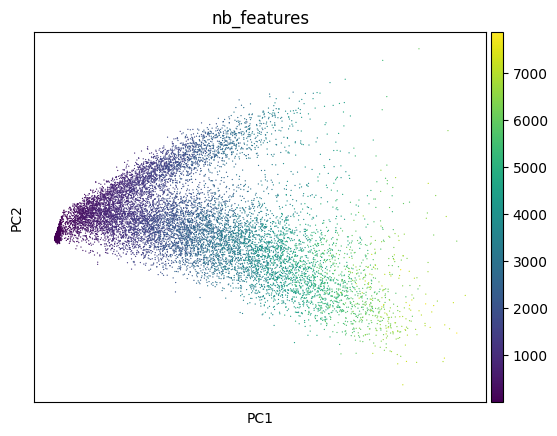

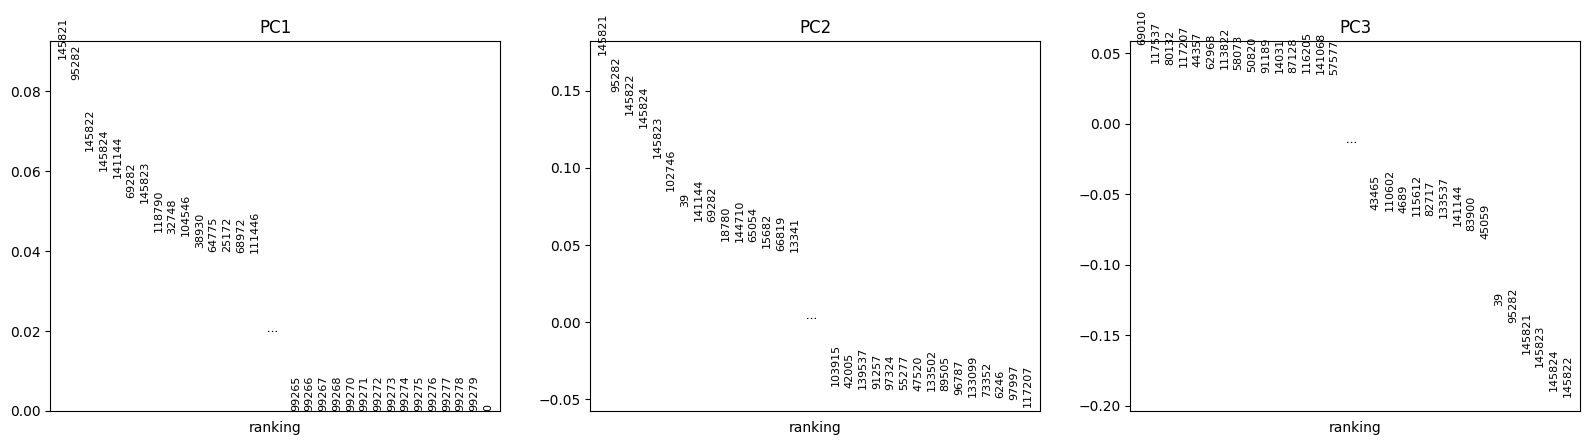

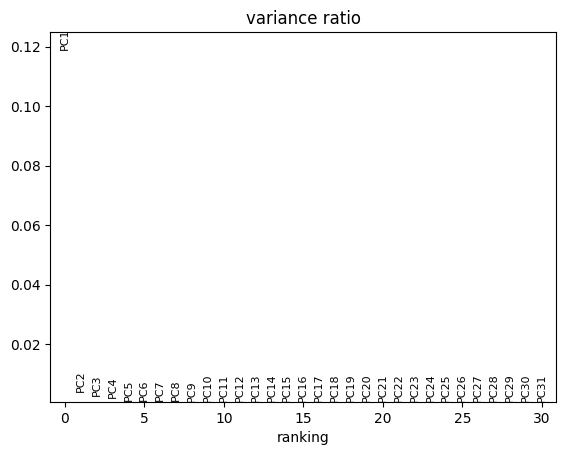

In [31]:
# Change to module
if save_figs:
    epi.pl.pca_overview(adata, color=['nb_features'], show=False)
    #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
    plt.show()
else:
    epi.pl.pca_overview(adata, color=['nb_features'])

In [32]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')

## UMAP

Computing UMAPs:   0%|          | 0/8 [00:00<?, ?it/s]

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initiali

Plotting umap for spread=2.0 and dist=0.1 (1/8)


KeyError: 'Could not find key Sample in .var_names or .obs.columns.'

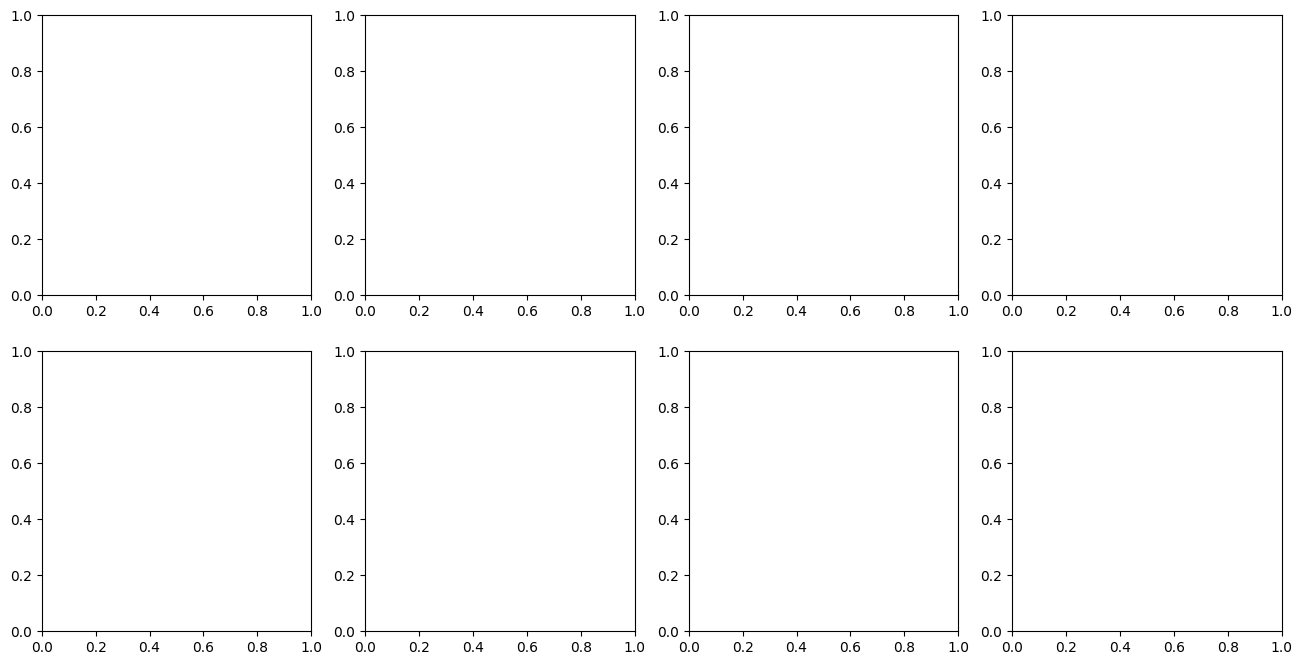

In [33]:
search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol='Sample', 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

## Plot

## Batch correction

In [ ]:
#Consider 

## save anndata